In [89]:
import utils
from IPython.display import Image as DisImage
import os
import cv2
import math
import numpy as np
from scipy.ndimage.filters import maximum_filter, minimum_filter
from functools import cmp_to_key

now_path = os.path.abspath(os.getcwd())

C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_11200\2064016106.py:7: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_11200\2064016106.py:7: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


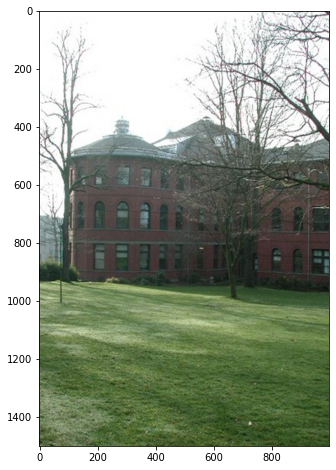

In [90]:
imgs = []
imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/parrington/prtn00.jpg')))
# imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/Elephant_Mountain/DSC00200-HDR.jpg')))

utils.imshow_plt(imgs[0])

In [91]:
def to_gaussian_list(img, s = 5, sigma = 1.6, input_blur = 0.5, interval_count = 3, plt_img = False):
    height, width, _ = img.shape
    std_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    std_img = cv2.resize(std_img, (width * 2, height * 2), cv2.INTER_LINEAR)
    # σ² = σ₁² + σ₂²
    sigma_diff = math.sqrt(max(0.01, sigma ** 2 - ((input_blur * 2) ** 2)))
    # Anti alias
    std_img = cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma_diff)
    octave_count = int(math.log2(min(width, height)) - 3)
    # 2 extra LoGs because we cant scan top and bottom layers
    img_count_perOctave = s + 3
    print(octave_count)
    DoGOctaves = []
    GaussianOctaves = []
    k = 2 ** (1 / s)

    for i in range(octave_count):
        gaussian_imgs = []
        gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma))
        # octave
        for j in range(1, img_count_perOctave):
            gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=(sigma * (k ** j))))
            print("Sigma:", sigma * (k ** j))
        GaussianOctaves.append(gaussian_imgs)
        DoGs = []
        for j in range(img_count_perOctave - 1):
            # DoGs.append(cv2.subtract(gaussian_imgs[j], gaussian_imgs[j + 1]))
            DoGs.append(gaussian_imgs[j].astype('float32') - gaussian_imgs[j + 1].astype('float32'))
        DoGOctaves.append(DoGs)
        # scale down image to speed up process
        std_img = cv2.resize(gaussian_imgs[-3], (width // (2 ** i), height // (2 ** i)))
        # sigma *= 2
        if plt_img:
            utils.imshows_plt(gaussian_imgs)
            utils.imshows_plt(DoGs)

    return DoGOctaves, GaussianOctaves

In [92]:
# DoGOctaves
"""
Octaves
[
    DoG Collection
    [
        DoG
    ]
]
"""

# GaussianOctaves
"""
GaussianOctaves
[
    Gaussians
    [
        
    ]
]
"""

'\nGaussianOctaves\n[\n    Gaussians\n    [\n        \n    ]\n]\n'

In [93]:
# to_gaussian_list(imgs[0], plt_img=True)

In [94]:
# def findMaxAndMinIn3x3x3(DoGs, DoGId, row, col):
#     for i in ra
#     maxVal = max(DoGs[DoGId][row][col], DoGs[DoGId][row][col], DoGs[DoGId][row][col])


In [95]:
DoGOctaves, GaussianOctaves = to_gaussian_list(imgs[0])

6
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985


In [96]:
def find_extrema_in_DoG(DoGOctave, OctaveLayersCount = 5, contrastThreshold = 0.4):
    # DoGOctaves
    """
    Octaves
    [
        DoGOctave
        [
            DoG
        ]
    ]
    """
    candidates = []
    # height, width = DoGs[0].shape
    maxConv = DoGOctave * (DoGOctave == maximum_filter(DoGOctave,footprint=np.ones((3,3,3))))
    minConv = DoGOctave * (DoGOctave == minimum_filter(DoGOctave,footprint=np.ones((3,3,3))))

    utils.imshow_plt(maxConv[0])
    threshold = int(0.5 * contrastThreshold / (OctaveLayersCount + 3) * 255)
    maxConvInds = np.argwhere(maxConv > threshold)
    minConvInds = np.argwhere(minConv < -threshold)

    print("Max len:", len(maxConvInds))
    print("min len:", len(minConvInds))

    # print(np.array(maxConvInds))

    candidates.extend(maxConvInds)
    candidates.extend(minConvInds)

    print("Extrema length:", len(candidates), candidates[0] if len(candidates) > 0 else "")

    keypoints = [[int(candidate[1]), int(candidate[2]), int(candidate[0])] for candidate in candidates]
    return keypoints

    

    
    

In [97]:
def get_parameters(D, row, col, sigma):
    """_summary_

    Args:
        D (list): octaves
        row (int): x of image
        col (int): y of image
        sigma (int): Index of image in a octave

    Returns:
        extremum: np.array(3)
        hessianXY: np.array((2, 2))
        gradient: np.array(3)
    """
    dx = (D[sigma][row, col + 1] - D[sigma][row, col - 1]) / 2.0
    dy = (D[sigma][row + 1, col] - D[sigma][row - 1, col]) / 2.0
    ds = (D[sigma + 1][row, col] - D[sigma - 1][row, col]) / 2.0

    dxx = D[sigma][row, col + 1] - 2 * D[sigma][row, col] + D[sigma][row, col - 1]
    dyy = D[sigma][row + 1, col] - 2 * D[sigma][row, col] + D[sigma][row - 1, col]
    dss = D[sigma + 1][row, col] - 2 * D[sigma][row, col] + D[sigma - 1][row, col]

    dxy = (D[sigma][row + 1, col + 1] - D[sigma][row + 1, col - 1] - D[sigma][row - 1, col + 1] + D[sigma][row - 1, col - 1]) / 4.0
    dxs = (D[sigma + 1][row, col + 1] - D[sigma + 1][row, col - 1] - D[sigma - 1][row, col + 1] + D[sigma - 1][row, col - 1]) / 4.0
    dys = (D[sigma + 1][row + 1, col] - D[sigma + 1][row - 1, col] - D[sigma - 1][row + 1, col] + D[sigma - 1][row - 1, col]) / 4.0

    gradient = np.array([dx, dy, ds])
    hessian = np.array([
                            [dxx, dxy, dxs],
                            [dxy, dyy, dys],
                            [dxs, dys, dss]
                        ])
    hessianXY = np.array([
                            [dxx, dxy],
                            [dxy, dyy]
                        ])

    extremum = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]

    if abs(extremum[0]) > 0.5 or abs(extremum[1]) > 0.5 or abs(extremum[2]) > 0.5:
        return None

    return extremum, hessianXY, gradient

    

In [98]:
def findScaleSpaceExtrema(DoGs, row, col, sigma_idx):
    height, width = DoGs[sigma_idx].shape
    sigma_size = len(DoGs)
    if row < 1 or row >= height - 1 or col < 1 or col >= width - 1 or sigma_idx < 1 or sigma_idx >= sigma_size - 1:
        return None
    var = get_parameters(DoGs, row, col, sigma_idx)
    if var is None:
        return None
    extremum, hessianXY, gradient = var
    iter_count = 0
    while abs(extremum[0]) > 0.5 or abs(extremum[1]) > 0.5 or abs(extremum[2]) > 0.5:
        # Offset larger than 0.5, its the point nearby
        row, col, sigma_idx = round(extremum[0]) + row, round(extremum[1]) + col, round(extremum[2]) + sigma_idx
        # Check boundry
        if row < 0 or row >= height or col < 0 or col >= width or sigma_idx < 0 or sigma_idx >= sigma_size:
            break
        var = get_parameters(DoGs, row, col, sigma_idx)
        if var is None:
            return None
        extremum, hessianXY, gradient = var
        iter_count += 1
        if iter_count > 3:
            print("WARNING!!! iteration count is", iter_count)
    contrast = abs(DoGs[sigma_idx][row, col]) + 0.5 * np.dot(gradient, extremum)
    if contrast < 0.03:
        # Contrast too low
        return None

    tr = np.trace(hessianXY)
    det = np.linalg.det(hessianXY)

    r = 10.0
    if (((r + 1) ** 2) * det) < ((tr ** 2) * r):
        # Discard edge response
        return None
        
    return row, col, sigma_idx, extremum


    

In [99]:
def get_gradients(octaves):
    magOctaves = []
    sitaOctaves = []
    for octave in octaves:
        magnitudes = []
        sitas = []
        for img in octave:
            dx = np.gradient(img, axis=1) * 2
            dy = np.gradient(img, axis=0) * 2
            magnitudes.append(np.sqrt(np.square(dx) + np.square(dy)))
            sitas.append(np.rad2deg(np.arctan2(dy, dx)))
        magOctaves.append(magnitudes)
        sitaOctaves.append(sitas)
    return magOctaves, sitaOctaves

In [100]:
class KeyPoint():

    def __init__(self, pointVecX:float, pointVecY:float, sigma_idx=0, size=0, octave=0, val=0, angle=0):
        self.pt = [pointVecX, pointVecY]
        self.sigma_idx = sigma_idx
        self.size = size
        self.octave = octave
        self.val = val
        self.angle = angle

    def __eq__(self, another):
        return hasattr(another, "pt") and\
            hasattr(another, "sigma_idx") and\
            hasattr(another, "size") and\
            hasattr(another, "octave") and\
            hasattr(another, "val") and\
            hasattr(another, "angle") and\
            int(self.pt[0]) == int(another.pt[0]) and\
            int(self.pt[1]) == int(another.pt[1]) and\
            self.sigma_idx == another.sigma_idx and\
            self.size == another.size and\
            self.octave == another.octave and\
            self.val == another.val and\
            self.angle == another.angle

    def __hash__(self):
        return hash((int(self.pt[0]), int(self.pt[1]), self.sigma_idx, self.size, self.octave, self.val, self.angle))

    def to_CV_keypoint(self):
        cv_keypnt = cv2.KeyPoint(self.pt[0], self.pt[1], self.size)
        cv_keypnt.octave = self.octave
        return cv_keypnt

In [101]:
def get_orientation(keypoint: KeyPoint, sigma_idx, magOctaves, sitaOctaves, scale_factor = 1.5, radius_factor=3, bin_count = 36):
    scale = scale_factor * keypoint.size / (2 ** (sigma_idx + 1))
    radius = int(scale * radius_factor)
    histogram = [0] * bin_count
    col, row = int(keypoint.pt[0] / (2 ** keypoint.octave)), int(keypoint.pt[1] / (2 ** keypoint.octave))
    octave_idx = keypoint.octave
    height, width = magOctaves[octave_idx][sigma_idx].shape
    for x in range(col - radius, col + radius + 1):
        for y in range(row - radius, row + radius + 1):
            # Check if point inside image
            if x < 0 or x >= width or y < 0 or y >= height:
                print("WARNING: outside boundry")
                continue
            histogram[int(sitaOctaves[octave_idx][sigma_idx][y, x] * bin_count / 360.0) % bin_count] += \
                (math.exp((-0.5 / (scale ** 2)) * ((x - col) ** 2 + (y - row) ** 2)) * magOctaves[octave_idx][sigma_idx][row, col])
    # utils.list_plt(histogram)
    top_val, top_idx = 0, 0
    sec_val, sec_idx = 0, 0
    for i in range(bin_count):
        if histogram[i] > sec_val:
            sec_val = histogram[i]
            sec_idx = i
        if histogram[i] > top_val:
            sec_val = top_val
            sec_idx = top_idx
            top_val = histogram[i]
            top_idx = i
    
    keypoint.val = top_val
    keypoint.angle = top_idx * 360 / float(bin_count)
    if top_val * 0.8 <= sec_val:
        keypnt2 = KeyPoint(keypoint.pt[0], keypoint.pt[1], keypoint.sigma_idx, keypoint.size, keypoint.octave, sec_val, sec_idx * 360 / float(bin_count))
        return [keypoint, keypnt2]
    else:
        return [keypoint]

In [102]:
def compare_CVKeypoint(kpA: KeyPoint, kpB: KeyPoint):
    if kpA.pt[0] != kpB.pt[0]:
        return kpA.pt[0] >= kpB.pt[0]
    elif kpA.pt[1] != kpB.pt[1]:
        return kpA.pt[1] >= kpB.pt[1]
    elif kpA.octave != kpB.octave:
        return kpA.octave >= kpB.octave
    elif kpA.size != kpB.size:
        return kpA.size >= kpB.size
    elif kpA.angle != kpB.angle:
        return kpA.angle >= kpB.angle
    else:
        print("WARNING!!!! Sort may be failed, please check.")
        return True

def remove_duplicate_keypnts(keypoints):
    if len(keypoints) < 2:
        return keypoints

    return list(dict.fromkeys(keypoints))



In [103]:
def get_descriptors(keypoints: list, magOctaves, sitaOctaves, bin_count=8, window_width=4, scale_mult=3, descrptr_max_val=0.2):
    descriptors = []
    """
    [pt[2], mag, angle]
    """

    for keypoint in keypoints:
        bin_pts = []
        mags = []
        angles = []

        octave = keypoint.octave
        print("DEBUG", octave, type(octave), keypoint.sigma_idx, type(keypoint.sigma_idx))
        height, width = magOctaves[octave][keypoint.sigma_idx].shape
        rot_angle = 360.0 - keypoint.angle
        cos = math.cos(math.radians(rot_angle))
        sin = math.sin(math.radians(rot_angle))
        histogram = np.zeros((window_width + 2, window_width + 2, bin_count))
        weighting = -0.5 / ((0.5 * window_width) ** 2.0)
        hist_width = scale_mult * 0.5 * keypoint.size
        half_width = int(round(hist_width * math.sqrt(2) * (window_width + 1) / 2.0))
        half_width = int(min(half_width, math.sqrt(height ** 2 + width ** 2)))

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                rot_row = col * sin + row * cos
                rot_col = col * cos - row * sin
                # minus 0.5 so we can get middle val
                row_bin = rot_row + window_width / 2.0 - 0.5
                col_bin = rot_col + window_width / 2.0 - 0.5
                row_idx = int(round((keypoint.pt[1] / (2.0 ** (octave - 1))) + row))
                col_idx = int(round((keypoint.pt[0] / (2.0 ** (octave - 1))) + col))
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width and\
                    row_idx > 0 and row_idx < height - 1 and col_idx > 0 and col_idx < width:
                    bin_pts.append([row_bin, col_bin])
                    weight = math.exp(weighting * ((rot_row / hist_width) ** 2.0 + (rot_col / hist_width) ** 2.0))
                    mags.append(magOctaves[octave][keypoint.sigma_idx][row_idx, col_idx] * weight)
                    angles.append((sitaOctaves[octave][keypoint.sigma_idx][row_idx, col_idx] - rot_angle) * (bin_count / 360.0))

        for bin_pts, mag, angle in zip(bin_pts, mags, angles):
            # Ref: https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-2-c4350274be2b
            row_bin_floor = math.floor(bin_pts[0])
            col_bin_floor = math.floor(bin_pts[1])
            orient_bin_floor = math.floor(angle)

            row_fraction = bin_pts[0] - row_bin_floor
            col_fraction = bin_pts[1] - col_bin_floor
            orient_fraction = angle - orient_bin_floor

            if orient_bin_floor < 0:
                orient_bin_floor += bin_count
            if orient_bin_floor >= bin_count:
                orient_bin_floor -= bin_count

            c0 = mag * (1 - row_fraction)
            c1 = mag * row_fraction
            c00 = c0 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c11 = c1 * col_fraction
            c000 = c00 * (1 - orient_fraction)
            c001 = c00 * orient_fraction
            c010 = c01 * (1 - orient_fraction)
            c011 = c01 * orient_fraction
            c100 = c10 * (1 - orient_fraction)
            c101 = c10 * orient_fraction
            c110 = c11 * (1 - orient_fraction)
            c111 = c11 * orient_fraction

            histogram[row_bin_floor + 1, col_bin_floor + 1, orient_bin_floor] += c000
            histogram[row_bin_floor + 1, col_bin_floor + 1, (orient_bin_floor + 1) % bin_count] += c001
            histogram[row_bin_floor + 1, col_bin_floor + 2, orient_bin_floor] += c010
            histogram[row_bin_floor + 1, col_bin_floor + 2, (orient_bin_floor + 1) % bin_count] += c011
            histogram[row_bin_floor + 2, col_bin_floor + 1, orient_bin_floor] += c100
            histogram[row_bin_floor + 2, col_bin_floor + 1, (orient_bin_floor + 1) % bin_count] += c101
            histogram[row_bin_floor + 2, col_bin_floor + 2, orient_bin_floor] += c110
            histogram[row_bin_floor + 2, col_bin_floor + 2, (orient_bin_floor + 1) % bin_count] += c111

        # Discard borders
        descriptor_vector = histogram[1:-1, 1:-1, :].flatten()
        threshold = np.linalg.norm(descriptor_vector) * descrptr_max_val
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(np.linalg.norm(descriptor_vector), 1e-7)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = np.round(512 * descriptor_vector)
        descriptor_vector = np.clip(descriptor_vector, 0, 255)
        descriptors.append(descriptor_vector)
    return np.array(descriptors, dtype='float32')





![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/3D_interpolation2.svg/345px-3D_interpolation2.svg.png)

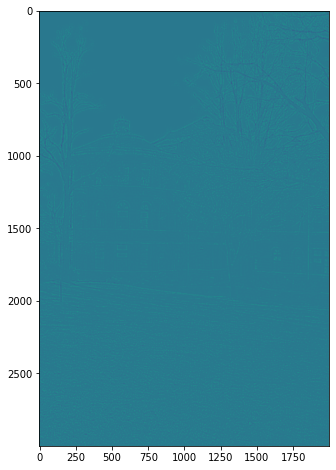

Max len: 2053
min len: 5530
Extrema length: 7583 [   2  524 1645]


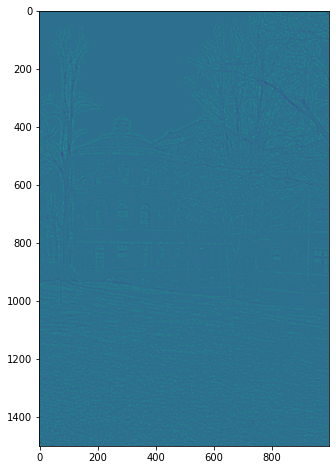

Max len: 485
min len: 1162
Extrema length: 1647 [  0   0 999]


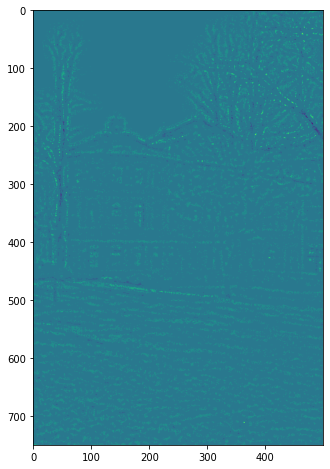

Max len: 67
min len: 160
Extrema length: 227 [  2 205 499]


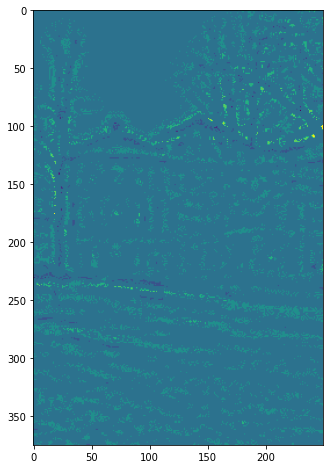

Max len: 0
min len: 55
Extrema length: 55 [  3   0 249]


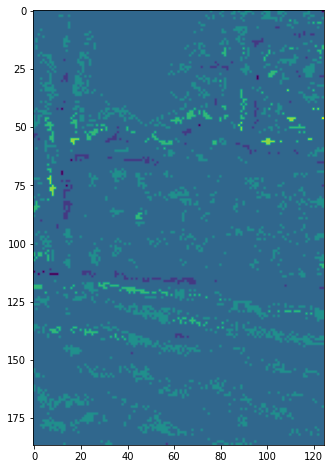

Max len: 0
min len: 0
Extrema length: 0 


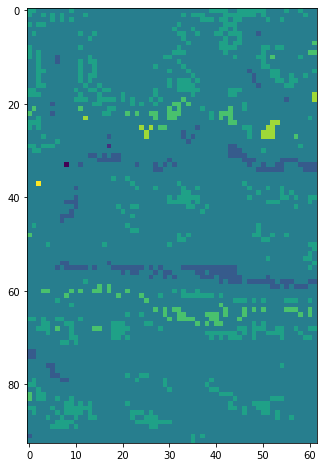

Max len: 9
min len: 0
Extrema length: 9 [ 4 38  0]
Discarded points : 8149
Total keypoints before remove duplicates : 1464
Total keypoints after remove duplicates : 1442
KP:  822.75 262.25
KP:  678.5083333333333 290.4791666666667
KP:  678.5083333333333 290.4791666666667
KP:  715.733870967742 580.991935483871
KP:  715.7690839694657 581.0381679389313
KP:  751.0232558139535 607.5930232558139
KP:  954.5097173144876 677.9231448763251
KP:  965.0 678.0833333333334
KP:  965.0 678.0833333333334
KP:  966.25 678.0
KP:  966.25 678.0
KP:  966.7659574468086 678.063829787234
KP:  995.75 678.0
KP:  995.75 678.0
KP:  749.491935483871 607.5645161290323
KP:  947.0105263157894 22.41578947368421
KP:  892.6666666666666 74.16666666666667
KP:  893.5 74.0
KP:  776.5833333333334 143.02173913043478
KP:  928.9583333333334 157.33333333333334
KP:  929.5 158.0
KP:  748.5 181.48947368421054
KP:  666.0833333333334 204.91666666666666
KP:  791.0 217.48947368421054
KP:  766.5106382978723 223.51063829787233
KP:  715.46774

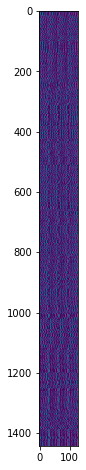

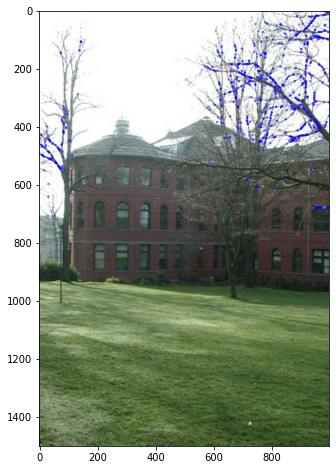

In [104]:
magOctaves, sitaOctaves = get_gradients(GaussianOctaves)
idv_keypoints = []
keypoint_dict = {}
discard_pnts_count = 0

for octave_idx, octave in enumerate(DoGOctaves):
    keypoints = find_extrema_in_DoG(DoGOctaves[octave_idx])
    for keypoint in keypoints:
        var = findScaleSpaceExtrema(DoGOctaves[octave_idx], keypoint[0], keypoint[1], keypoint[2])
        if var is not None:
            row, col, sigma_idx, extremum = var
            if (row, col) not in keypoint_dict:
                sigma = 1.6
                keypoint_size = sigma * (2 ** ((sigma_idx + extremum[2]) / 3.0)) * (2 ** (octave_idx + 1))
                keypnt = KeyPoint((col + extremum[0]) * (2 ** octave_idx), (row + extremum[1]) * (2 ** octave_idx), sigma_idx=sigma_idx, size=keypoint_size)
                keypnt.octave = octave_idx
                idv_keypoints.extend(get_orientation(keypnt, sigma_idx, magOctaves, sitaOctaves))
                # keypoint_dict[(row, col)] = 1
        else:
            discard_pnts_count += 1

print("Discarded points :", discard_pnts_count)

print("Total keypoints before remove duplicates :", len(idv_keypoints))
idv_keypoints = remove_duplicate_keypnts(idv_keypoints)
print("Total keypoints after remove duplicates :", len(idv_keypoints))
for idv_keypoint in idv_keypoints:
    idv_keypoint.pt[0] /= 2.0
    idv_keypoint.pt[1] /= 2.0
    idv_keypoint.size /= 2.0
    print("KP: ", idv_keypoint.pt[0], idv_keypoint.pt[1])



descrptrs = get_descriptors(idv_keypoints, magOctaves, sitaOctaves)
utils.imshow_plt(descrptrs)
cv_keypoints = [kpnt.to_CV_keypoint() for kpnt in idv_keypoints]

im_key = cv2.drawKeypoints(imgs[0], cv_keypoints, np.array([]), (255, 0, 0))
# im_key = cv2.drawKeypoints(imgs, cv_keypoints, np.array([]), (255, 0, 0))

utils.imshow_plt(im_key)

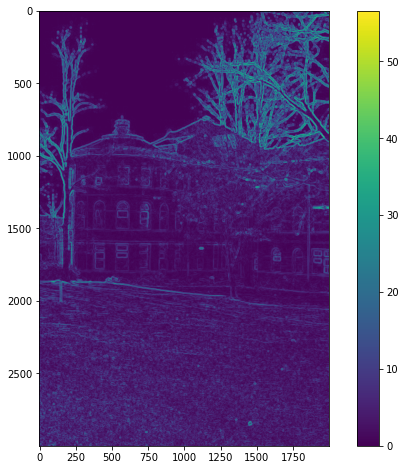

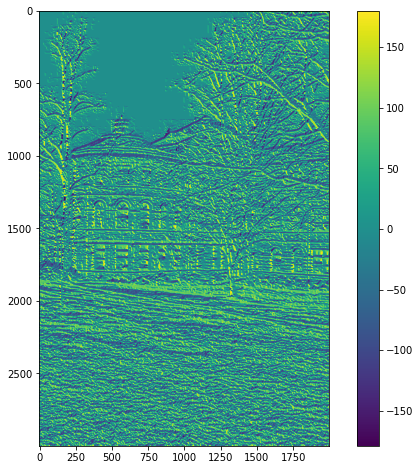

In [105]:
magOctaves, sitaOctaves = get_gradients(GaussianOctaves)

utils.imshow_plt(magOctaves[0][0], color_bar=True)
utils.imshow_plt(sitaOctaves[0][0], color_bar=True)
